<a href="https://colab.research.google.com/github/mijanr/TimeSeries/blob/master/Time-Series%20Classification/cnn_plus_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import necessary modules
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam

import numpy as np
from sklearn.metrics import accuracy_score
from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler, TimeSeriesScalerMinMax

from typing import List
import matplotlib.pyplot as plt

In [3]:
dataset_name = 'ElectricDevices'

In [4]:
# Load and preprocess the time series data
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset(dataset_name)

In [45]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([8926, 96, 1]),
 torch.Size([8926]),
 torch.Size([7711, 96, 1]),
 torch.Size([7711]))

In [6]:
#normalize the data
X_train = TimeSeriesScalerMinMax().fit_transform(X_train)
X_test = TimeSeriesScalerMinMax().fit_transform(X_test)

In [6]:
# Resample the data to 128 time steps
# X_train = TimeSeriesResampler(sz=128).fit_transform(X_train)
# X_test = TimeSeriesResampler(sz=128).fit_transform(X_test)

In [7]:
# Convert the data to torch tensors
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train).long()
y_test = torch.from_numpy(y_test).long()

In [8]:
#start class from 0
y_train = y_train - 1
y_test = y_test - 1

In [9]:
#Datasets
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
#Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [31]:
for i, (x,y) in enumerate(train_loader):
    print(x.shape)

torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 

In [11]:
# model 1: CNN + LSTM
# model 2: LSTM + CNN
# model 3: CNN LSTM parallel

class CNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CNN_LSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )
        self.lstm = nn.LSTM(input_size=128, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x = x.permute(0, 2, 1)
        out = self.cnn(x)
        # lstm takes input of shape (batch_size, seq_len, input_size)
        out = out.permute(0, 2, 1)
        out, _ = self.lstm(out)
        out = self.fc(out[:, -1, :])
        return out

In [12]:
class LSTM_CNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_CNN, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=hidden_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            #flatten
            nn.Flatten(),
            nn.LazyLinear(out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=num_classes)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out.permute(0, 2, 1)
        out = self.cnn(out)
        return out

In [13]:
# model 3: CNN LSTM parallel
class ParallelCNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(ParallelCNNLSTMModel, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(out_features=128),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_lstm = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128*2, num_classes)

    def forward(self, x):
        #cnn takes input of shape (batch_size, channels, seq_len)
        x_cnn = x.permute(0, 2, 1)
        out_cnn = self.cnn(x_cnn)
        # lstm takes input of shape (batch_size, seq_len, input_size)
        out_lstm, _ = self.lstm(x)
        out_lstm = self.fc_lstm(out_lstm[:, -1, :])
        out = torch.cat([out_cnn, out_lstm], dim=1)
        out = self.fc(out)
        return out

In [14]:
input_size = X_train.shape[-1]
hidden_size = 128
num_layers = 2
num_classes = len(np.unique(y_train))

cnn_lstm = CNN_LSTM(input_size, hidden_size, num_layers, num_classes).to(device)
lstm_cnn = LSTM_CNN(input_size, hidden_size, num_layers, num_classes).to(device)
cnn_lstm_parallel = ParallelCNNLSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)

/Users/oliverchang/opt/anaconda3/envs/vista/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [17]:
def train(models:List, train_loader:DataLoader, epochs:int):
    criterion = nn.CrossEntropyLoss()
    for model in models:
        print("Training model: ", model.__class__.__name__)
        model.train()
        optimizer = Adam(model.parameters(), lr=0.001)
        for epoch in range(epochs):
            for i, (x, y) in enumerate(train_loader):
                x = x.to(device)
                print(x.shape)
                y = y.to(device)
                optimizer.zero_grad()
                y_pred = model(x)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()
                if (i+1) % 10 == 0:
                    print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        print("Training completed for model: ", model.__class__.__name__)

In [18]:
#train
models = [cnn_lstm, lstm_cnn, cnn_lstm_parallel]
num_epochs = 200
train(models, train_loader, epochs=num_epochs)

Training model:  CNN_LSTM
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
Epoch [1/200], Step [10/140], Loss: 0.9359
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
Epoch [1/200], Step [20/140], Loss: 0.8671
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])
torch.Size([64, 96, 1])


KeyboardInterrupt: 

In [103]:
#test
def test(models, test_loader):
    with torch.no_grad():
        correct = 0
        total = 0
        accuracy_dict = {}
        for model in models:
            model.eval()
            for x, y in test_loader:
                x = x.to(device)
                y = y.to(device)
                y_pred = model(x)
                _, predicted = torch.max(y_pred.data, 1)
                total += y.size(0)
                correct += (predicted == y).sum().item()
            print(f'Accuracy of the {model.__class__.__name__} model on the test set: {100 * correct / total:.2f} %')
            accuracy_dict[model.__class__.__name__] = 100 * correct / total
    return accuracy_dict

In [104]:
accuracy_dict = test(models, test_loader)

Accuracy of the CNN_LSTM model on the test set: 72.27 %
Accuracy of the LSTM_CNN model on the test set: 69.73 %
Accuracy of the ParallelCNNLSTMModel model on the test set: 69.84 %


<AxesSubplot: >

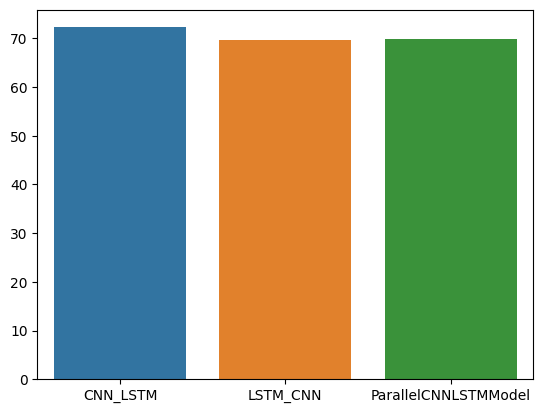

In [107]:
#plot bar chart with the accuracy of each model
sns.barplot(x=list(accuracy_dict.keys()), y=list(accuracy_dict.values()))